# Modelo de Bateria

In [11]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
import pandas as pd
from battery_utils import v_mid, v_inf, v_sup, cs_r0, cs_r1, cs_r2, cs_c1, cs_c2
from scipy import integrate

## Execução

### Componentes e OVC em função do SoC

In [2]:
cs_mid = v_mid()

def OCV(z):
    if z<0.089:
        return cs_mid(0.089)
    if z>1:
        return cs_mid(1)
    return cs_mid(z)

def r0(z):
    if z<0.089:
        return cs_r0(0.089)

    return cs_r0(z)

def r1(z):
    if z<0.089:
        return cs_r1(0.089)

    return cs_r1(z)

def c1(z):
    if z<0.089:
        return cs_c1(0.089)

    return cs_c1(z)

def r2(z):
    if z<0.089:
        return cs_r2(0.089)

    return cs_r2(z)


def c2(z):
    if z<0.089:
        return cs_c2(0.089)

    return cs_c2(z)


### Update dos valores

In [3]:
def update_z(z, Q, n, i, d_t):
    '''
    z: SoC
    Q: capacidade total (As)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (s)
    '''
    d_h = d_t/3600
    z -= n*i*(d_h/Q)
    return max(z,0)

In [4]:
def update_v(z, i_r0, i_r1, i_r2=0):
    ocv = OCV(z)
    return ocv - i_r0*r0(z) - i_r1*r1(z) - i_r2*r2(z)

In [5]:
#d_t em segundos nessa equação
def update_i_r1(z, i_r0, i_r1, d_t):
    e = np.exp(-d_t/(c1(z)*r1(z)))
    return i_r1*e+i_r0*(1-e)

def update_i_r2(z, i_r0, i_r2, d_t):
    e = np.exp(-d_t/(c2(z)*r2(z)))
    return i_r2*e+i_r0*(1-e)

### Carregando I e t

In [6]:
WS = pd.read_excel('./Dados_C100_patricio.xlsx')
df_c100 = ps.DataFrame(WS)
df_c100.drop('Unnamed: 0')
df_c100 = df_c100[:-17000].select([
    ps.col('Corrente [A]').alias('I'),
    ps.col('Tempo [s]').alias('t'),
    ps.col('Tensão [V]').alias('V')
    ])

In [20]:
# d_t = 0.01 # variação no tempo (s)
dt_array = (df_c100['t']-df_c100['t'].shift(1)).to_numpy()
dt_array[0] = dt_array[1]
# i0 = 100 # corrente (A)
# pausa = int(3600/d_t)
# descarga = int(pausa*0.1)
# I0 = ([0.0]*pausa+[i0]*descarga)*10 # corrente (A)
I0 = -df_c100['I'].to_numpy()
cumsum = np.append([0], integrate.cumulative_trapezoid(df_c100['I'].to_numpy(), x=df_c100['t'].to_numpy()))
df_c100['Z'] = 1-cumsum/cumsum.min()

### Loop de execução

In [34]:
z = 1 # SoC
Q = 271.6 # capacidade total (Ah) (100Ah)
n = 1 # eficiência coulombiana/carga
i_r1 = 0 # corrente (A)
i_r2 = 0 # corrente (A)

V = []
I1 = []
Z = []
t = [0,]
for dt, i_r0 in zip(dt_array, I0):
    i_r0 *= 1.07
    if z <= 0:
        I0 = I0[:len(V)]
        break
    # Update dos valores
    z = update_z(z, Q, n, i_r0, dt)
    v = update_v(z, i_r0, i_r1, i_r2)

    i_r1 = update_i_r1(z, i_r0, i_r1, dt)
    i_r2 = update_i_r2(z, i_r0, i_r2, dt)

    # Armazenamento dos valores
    t.append(t[-1]+dt)
    V.append(v)
    Z.append(z)
    I1.append(i_r1)


df = ps.DataFrame(data={'t':t[1:],'V': V, 'I0': I0, 'Z': Z})
df['dV'] = df['V'].diff()
df['dI'] = df['I0'].diff()

### Gráficos

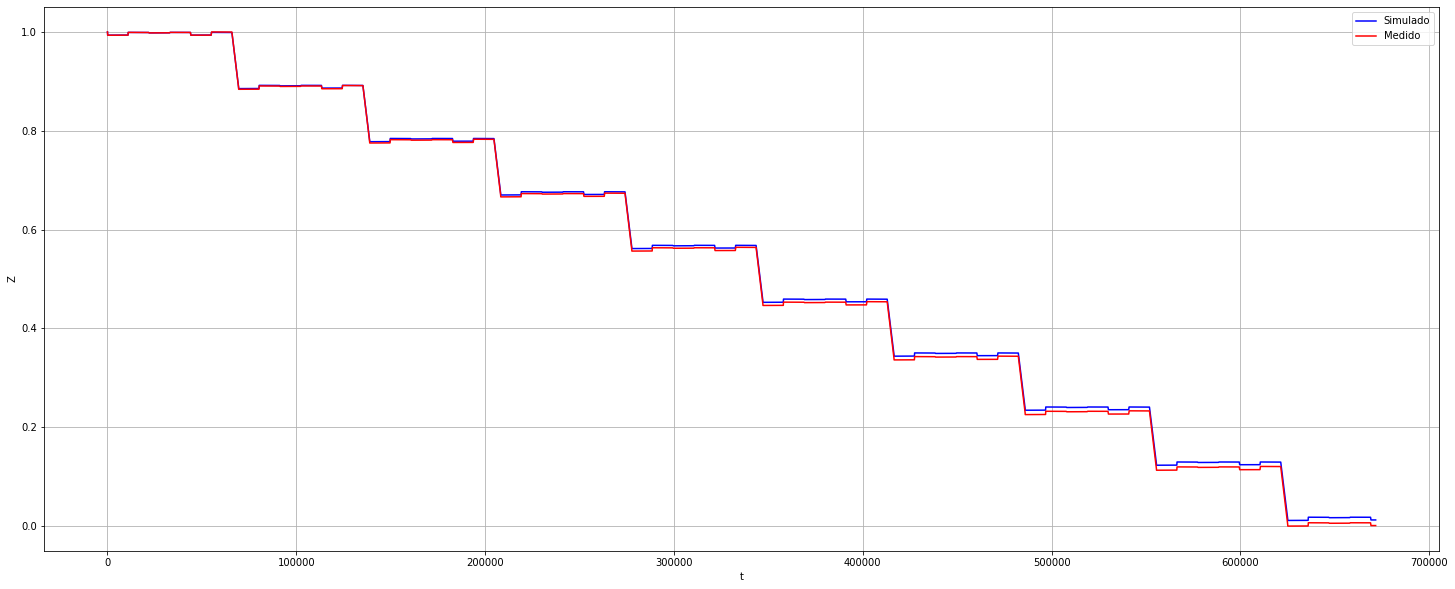

In [35]:
plt.figure(figsize=(25, 10))
sns.lineplot(data=df.to_pandas(), x='t', y='Z', label='Simulado', color='blue')
sns.lineplot(data=df_c100.to_pandas(), x='t', y='Z', label='Medido', color='red')
plt.grid()
plt.show()
plt.close()

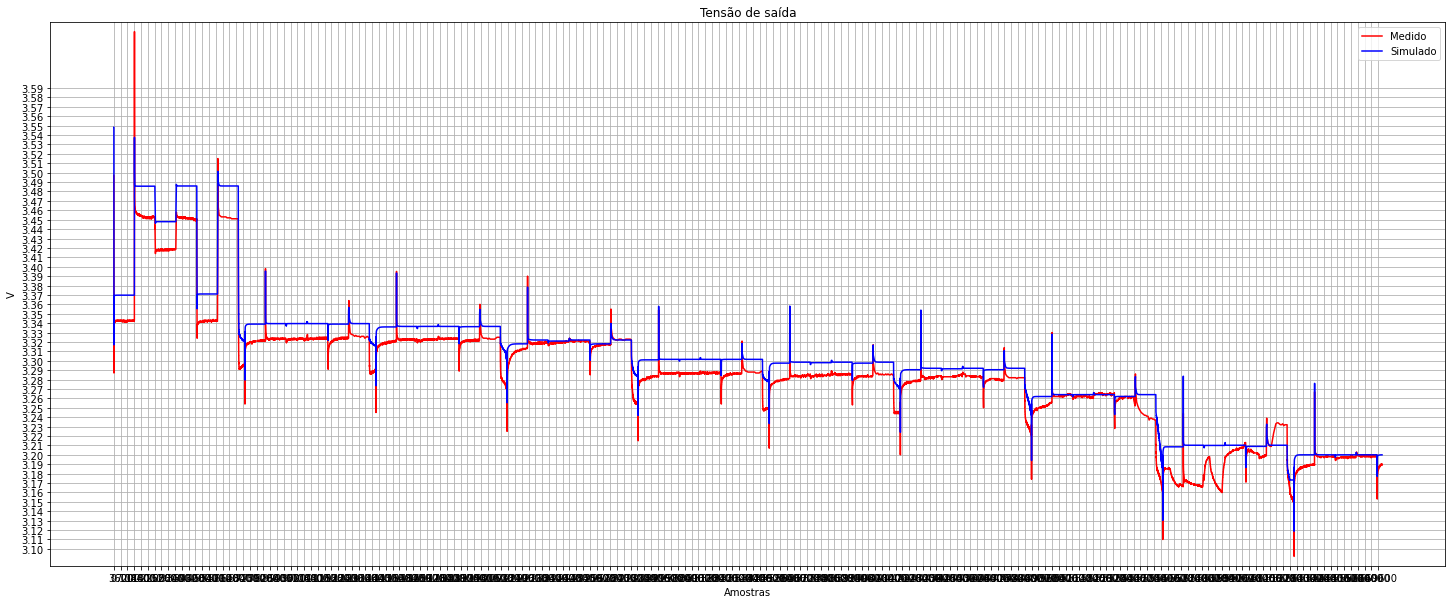

In [36]:
plt.figure(figsize=(25, 10))
sns.lineplot(data=df_c100.to_pandas(), x='t', y='V', label='Medido', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V', label='Simulado', color='blue')
plt.ylabel('V')
plt.xlabel('Amostras')
plt.title('Tensão de saída')
plt.xticks(np.arange(0, df['t'].max(), step=3600))
plt.yticks(np.arange(3.1, 3.6, step=0.01))
plt.ylim([df_c100['V'].min()-0.01, df_c100['V'].max()+0.01])
#plt.xlim([0, len(V)])
plt.grid()
plt.show()
plt.close()